In [ ]:
import micropip

In [ ]:
await micropip.install("ipywidgets")

In [26]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from ipywidgets import interactive
# %matplotlib notebook
%matplotlib inline

### Method overview:

1. Create a histogram of annual electricity price using an inverse Weibull distribution. This is controlled by minimum value, scale, and shape parameters. This distribution isn't representative of all markets or future price distributions.

2. Calculate the annual revenue a 1MWe plant would receive as a function of the number of hours it operated per year, aka. it's annual utilization. This ignores hour-to-hour operational constraints.

3. Given the nameplate vessel lifetime and vessel replacement duration, calculate the maximum possible annual utilization if we annuitize the vessel replacement process.

4. For each valid annual utilization value, in increments of 1hr, calculate the number of vessels required over the plant lifetime (which is also a user input).

5. For each valid annual utilization value, calculate the annuitized costs of operating a 1MWe plant. Note, we've not included regular variable costs which scale with utilization.

6. Take the difference of the annual revenue and costs and plot in an ipywidget.

In [27]:
def vessel_plot(
    invw_shift, # [$/MWhe] minimum electricity price
    invw_shape, # shape parameter of the inverse Weibull distribution 
    invw_scale, # scale parameter of the inverse Weibull distribution
    plant_cost, # [$ / kWe] cost of the plant, except for the vacuum vessel
    vessel_cost, # [$ / kWe] cost of the vacuum vessel
    plant_lifetime, # [years] lifetime of the plant
    vessel_lifetime, # [years] lifetime of the vacuum vessel
    replacement_duration, # [years] time required to replace the vacuum vessel
    discount_rate # [% / year] discount rate
    ):

    # Hard-coded parameters
    T = 8760 # hours in a year

    max_lmp = invw_shift + invw_scale * ( -np.log(0.99) )**(-1/invw_shape)
    lmp = np.arange(0, max_lmp, 1)
    lmp_pmf = stats.invweibull.pdf(lmp, c=invw_shape, loc=0,scale=invw_scale) * T
    lmp += invw_shift
    lmp_invcdf = stats.invweibull.ppf(np.arange(0, T, 1)/T, c=invw_shape, loc=0,scale=invw_scale) + invw_shift
    rev_lmp_invcdf = np.flip(lmp_invcdf)

    max_util = (-vessel_lifetime + (vessel_lifetime**2 + 4 * vessel_lifetime * replacement_duration)**0.5) / 2 / replacement_duration
    time_hrs = np.arange(1, np.floor(8760 * max_util))
    util = np.linspace(1/8760, max_util, len(time_hrs))
    
    num_vessel = plant_lifetime / (vessel_lifetime / util + replacement_duration)
    costs = discount_rate / (1 - (1 + discount_rate)**-plant_lifetime) * (plant_cost + num_vessel * vessel_cost)
    revenue_trunc = np.cumsum(rev_lmp_invcdf)[:int(np.max(time_hrs))]
    profit = revenue_trunc - costs * 1000 # Costs were $/kWhe while revenue was $/MWh

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].bar(lmp, lmp_pmf, width=1, color='xkcd:kelly green')
    ax[0].set_xlim([0, max_lmp])
    ax[0].set_ylabel("Hours per year", fontsize=16)
    ax[0].set_xlabel("LMP [$ / MWhe]", fontsize=16)

    ax[1].plot(time_hrs, profit, color='xkcd:dark blue')
    ax[1].set_xlim([0, 8760])
    ax[1].set_ylabel("Profit [$ / yr]", fontsize=16)
    ax[1].set_xlabel("Hours operated per year", fontsize=16)

    plt.tight_layout()
    plt.show()

interactive_plot = interactive(
    vessel_plot, 
    invw_shift=(0, 40, 1.0),
    invw_shape=(1.0, 3.0), 
    invw_scale=(10, 30.0),
    plant_cost=(0.0, 6000.0, 250.0),
    vessel_cost=(100.0, 1000.0, 100.0),
    plant_lifetime=(5.0, 80.0, 5.0),
    vessel_lifetime=(0.25, 10.0, 0.25),
    replacement_duration=(0.05, 0.5, 0.05),
    discount_rate=(0.01, 0.2, 0.01)
)

### Inputs:

- invw_shift [\$]: approximately the minimum price of electricity
- invw_shape [-]: the steepness of the electricity price distribution. Lower values = higher prices
- invw_scale [\$]: affects the spread of the electricity price distribution. Lower values = lower prices

- plant_cost [\$/kWe]: capital cost for the plant, excluding the vacuum vessel
- vessel_cost [\$/kWe/vessel]: capital and replacement cost for each vacuum vessel, per kWe

- plant_lifetime [year]: lifetime of the entire fusion power plant
- vessel_lifetime [year]: nameplate lifetime of each vacuum vessel, assuming 100% utilization
- replacement_duration [year]: time required for vacuum vessel replacement and planned maintenance

- discount_rate [-]: discount rate / WACC

In [28]:
interactive_plot

interactive(children=(FloatSlider(value=20.0, description='invw_shift', max=40.0, step=1.0), FloatSlider(value…

### Static plots showing behaviour across variables:

Unless otherwise noted, the plots above assume:
- plant cost: $3000/kWe
- vessel cost: $500/kWe
- plant lifetime: 40 years
- vessel lifetime: 4 years
- replacement duration: 0.25 years
- discount rate: 6%

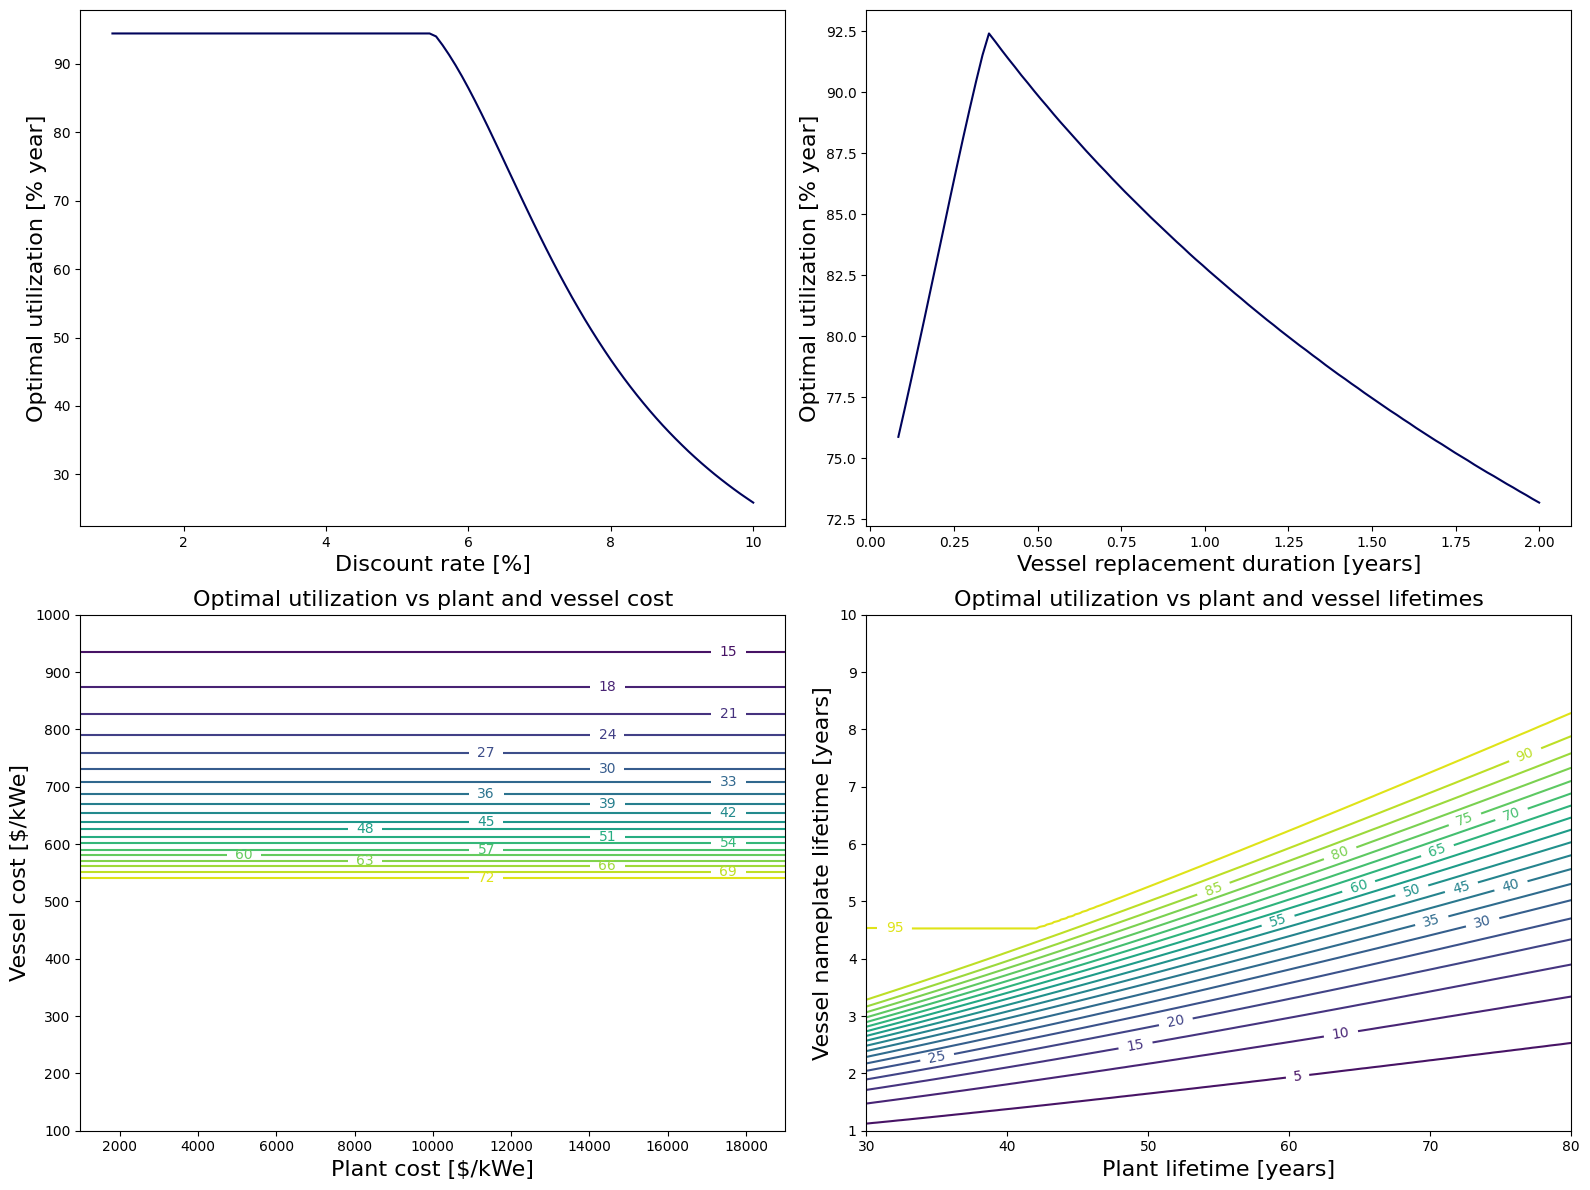

In [4]:
from IPython.display import Image
Image(filename='static_fusion_plots.png') 
# !["Static plots"]( "Static plots")